# Phase 2 - Exploratory analysis
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

##Importing libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

In [52]:
profiles_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/profiles.csv', sep='\t')
connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
devices_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/devices.csv', sep='\t')
processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')

In [53]:
devices_data = devices_data.dropna()
df_unique = devices_data.drop_duplicates(subset=['imei'], keep='first')
# Перевіряємо розмірність датафрейму
df_unique.shape[0]

500

In [64]:
result = pd.merge(df_unique, processes_data, on='imei', how='right')

In [58]:
result.shape[0]

15145

In [59]:
result.dropna()
result.shape[0]

15145

In [78]:
connections_data['ts'].equals(processes_data['ts']) and connections_data['mwra'].equals(processes_data['mwra']) and connections_data['imei'].equals(processes_data['imei'])

True

In [89]:
merged_data = pd.merge(df_unique, pd.merge(processes_data, connections_data).drop_duplicates(), on='imei', how='right')

In [90]:
merged_data.shape[0]

14965

In [91]:
merged_data.dropna()
merged_data.shape[0]

14965

In [96]:
merged_data[['continent', 'city']] = merged_data['location'].str.split('/', expand=True, n=1).apply(lambda x: x.tolist() if len(x.dropna()) > 1 else [x[0], None], axis=1, result_type='expand')

In [97]:
merged_data = merged_data.drop('location', axis=1)

In [98]:
continent_mapping = {
    'Asia': 1,
    'America': 2,
    'Europe': 3,
    'Africa': 4,
    'Australia': 5,
    'Indian': 6,
    'Pacific': 7
}

# Застосуємо мапінг до стовпця 'continent'
merged_data['continent'] = merged_data['continent'].map(continent_mapping)

In [99]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14965 entries, 0 to 14964
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    14965 non-null  float64
 1   longitude                   14965 non-null  float64
 2   store_name                  14965 non-null  object 
 3   code                        14965 non-null  object 
 4   imei                        14965 non-null  int64  
 5   ts                          14965 non-null  object 
 6   mwra                        14965 non-null  float64
 7   p.android.packageinstaller  14965 non-null  float64
 8   p.system                    14965 non-null  float64
 9   p.android.externalstorage   14965 non-null  float64
 10  p.android.documentsui       14965 non-null  float64
 11  p.android.gm                14965 non-null  float64
 12  p.android.settings          14965 non-null  float64
 13  p.android.chrome            149

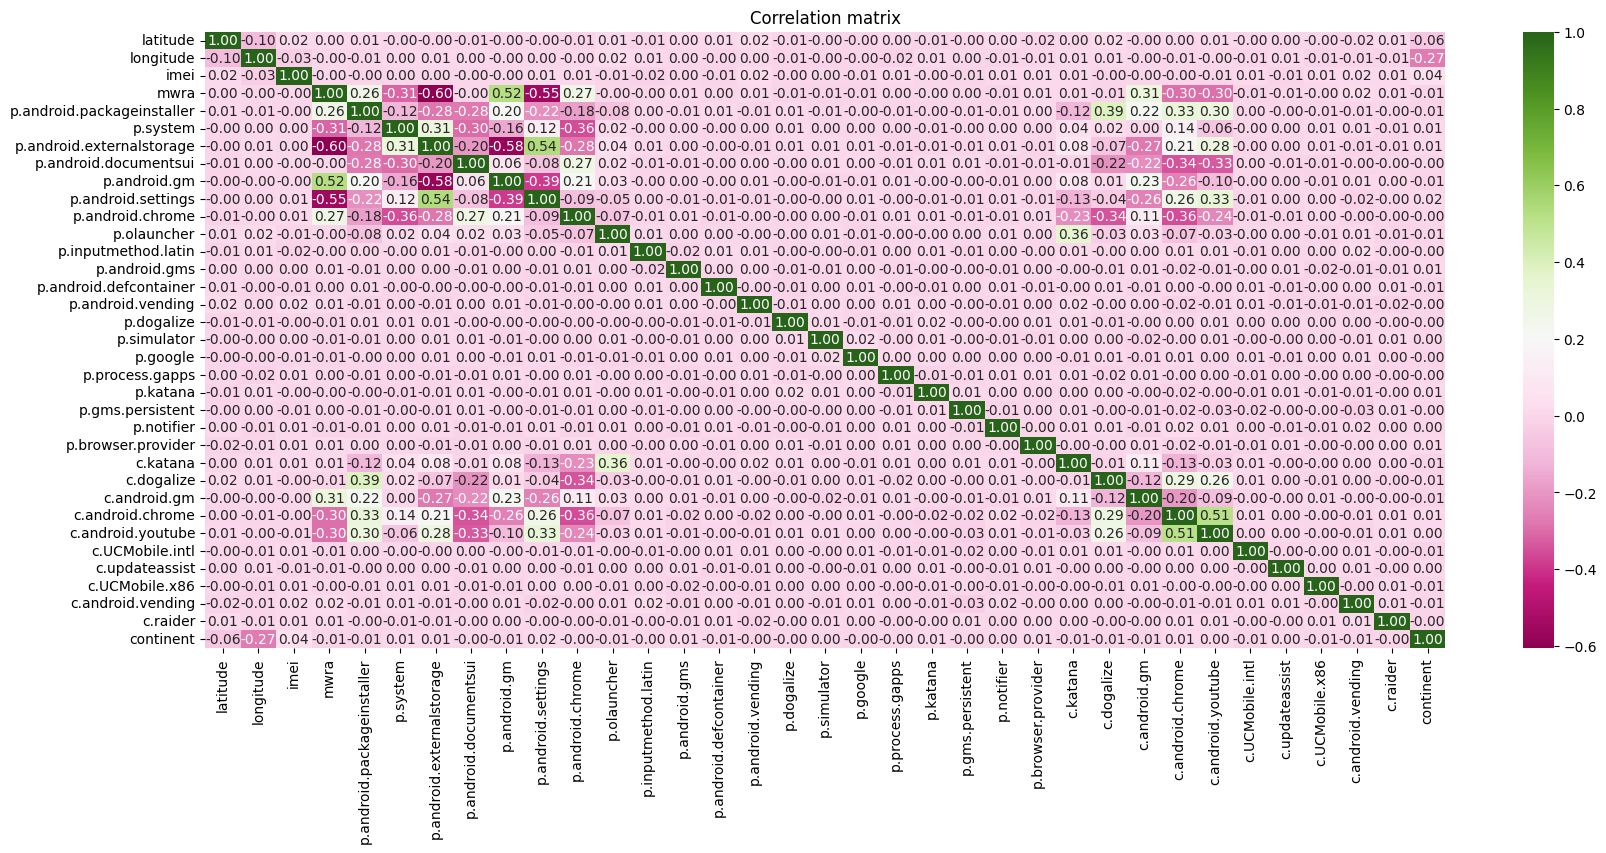

In [101]:
numeric_cols = merged_data.select_dtypes(include=[np.number, np.datetime64])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, fmt='.2f', annot=True, cmap='PiYG')
plt.title('Correlation matrix')
plt.show()